# **Feature Engineering**

I am slightly skeptical of the high evaluation scores. There is a chance that there is some data leakage occurring. Data leakage is when you use data to train your model that should not be used during training, either because it appears in the test data or because it's not data that you'd expect to have when the model is actually deployed. Training a model with leaked data can give an unrealistic score that is not replicated in production.

In this case, it's likely that the company won't have satisfaction levels reported for all of its employees. It's also possible that the `average_monthly_hours` column is a source of some data leakage. If employees have already decided upon quitting, or have already been identified by management as people to be fired, they may be working fewer hours. 

The first round of decision tree, random forest and XGBoost models included all variables as features. In the next round I will incorporate feature engineering to build improved models. 

### Importing packages

In [22]:
 # For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import joblib

In [23]:
# Importing custom functions from utils file that I created for this project
from utils import explore_outlier
from utils import remove_outlier
from utils import make_results
from utils import get_scores
from utils import stratified_split_no_data_leakage   
from utils import plot_classification_matrix

In [24]:
# Loading the data
df = pd.read_csv('hr_dataset_encoded.csv')

In [25]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df2 = df.drop('satisfaction_level', axis=1)

# Display first few rows of new dataframe
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [26]:
# Creating `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_monthly_hours']

# max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. 

Being overworked is working more than 175 hours per month on average.

To make the `overworked` column binary, I will reassign the column using a boolean mask.
- `df2['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
- `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [27]:
# Defining `overworked` as working > 175 hrs/week
df2['overworked'] = (df2['overworked'] > 175).astype(int)

# Display first few rows of new column
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [28]:
# Dropping the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)

df2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


## Changes made to the dataset
### - "satisfaction" column dropped
### - "average_monthly_hours" column replaced with "overworked" column

Spliting the data into training and testing sets.

In [29]:
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df2, target_col='left')

#### Decision tree - Round 2

In [30]:
# Instantiating Decision tree model
tree2 = DecisionTreeClassifier(random_state=0)

# Dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Dictionary of scoring metrics to capture
scoring = {'accuracy' : 'accuracy',
            'f1' : 'f1',
            'precision' : 'precision',
            'recall' : 'recall',
            'roc_auc' : 'roc_auc'}

# Instantiating GridSearch
tree2_cv = GridSearchCV(tree2, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [31]:
%%time
tree2_cv.fit(X_train, y_train)

CPU times: total: 9.09 s
Wall time: 9.27 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [32]:
# Saving the cv model to a file
joblib.dump(tree2_cv, 'tree2_cv.pkl')

['tree2_cv.pkl']

In [33]:
# Loading the cv model from a file
tree2_cv = joblib.load('tree2_cv.pkl')

In [34]:
# Best parameters on CV
tree2_cv.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [35]:
# Best AUC score on CV
tree2_cv.best_score_

np.float64(0.974838779287411)

In [76]:
# Score of best estimator model on test data
tree2_test_score = get_scores('Decision tree model 2', tree2_cv, X_test, y_test)
print(tree2_test_score)

                   model  precision    recall        f1  accuracy       AUC
0  Decision tree model 2   0.925926  0.881523  0.903179  0.954714  0.929651


This model performs very well, even without satisfaction levels and detailed hours worked data. 

Next, checking other scores.

In [ ]:
# Loading the decision tree cv object from round one
tree1_cv = joblib.load('tree1_cv.pkl')

In [37]:
# All scores for tree cv objects
tree1_cv_results = make_results('decision tree1 cv', tree1_cv, 'auc')
tree2_cv_results = make_results('decision tree2 cv', tree2_cv, 'auc')

print(tree1_cv_results)
print(tree2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree1 cv   0.948726  0.943019  0.945782    0.9741  0.983501
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.899059  0.888465  0.892618  0.949291  0.974839


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

#### Random forest - Round 2

In [38]:
# Instantiating model
rf2 = RandomForestClassifier(random_state=0)

# Dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Dictionary of scoring metrics to capture
scoring = {'accuracy' : 'accuracy',
            'f1' : 'f1',
            'precision' : 'precision',
            'recall' : 'recall',
            'roc_auc' : 'roc_auc'}

# Instantiating GridSearch
rf2_cv = GridSearchCV(rf2, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [39]:
%%time
rf2_cv.fit(X_train, y_train) 

CPU times: total: 33min 20s
Wall time: 33min 35s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [40]:
# Saving the model to a file
joblib.dump(rf2_cv, 'rf2_cv.pkl')

['rf2_cv.pkl']

In [41]:
# Loading the model from a file
rf2_cv = joblib.load('rf2_cv.pkl')

In [42]:
# Best parameters on CV
rf2_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}

In [43]:
# Best AUC score on CV
rf2_cv.best_score_

np.float64(0.9838758245016694)

In [44]:
# Loading the random forest cv object from round one
rf1_cv = joblib.load('rf1_cv.pkl')

In [45]:
# All CV scores
rf1_cv_results = make_results('random forest1 cv', rf1_cv, 'auc')
rf2_cv_results = make_results('random forest2 cv', rf2_cv, 'auc')
print(rf1_cv_results)
print(rf2_cv_results)
print(tree2_cv_results)

               model  precision    recall       F1  accuracy       auc
0  random forest1 cv   0.980054  0.934175  0.95648   0.97962  0.992107
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.914877  0.932994  0.923141  0.963305  0.983876
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.899059  0.888465  0.892618  0.949291  0.974839


Again, the scores dropped slightly, but the random forest performs better than the decision tree. 

In [80]:
# Scoring the random forest model on the test set now.
rf2_test_scores = get_scores('random forest model 2', rf2_cv, X_test, y_test)
rf2_test_scores


,model,precision,recall,f1,accuracy,AUC
0,random forest model 2,0.935681,0.861777,0.89721,0.952687,0.921555


This seems to be a stable, well-performing model. 

Plotting a confusion matrix to visualize how well it predicts on the test set.

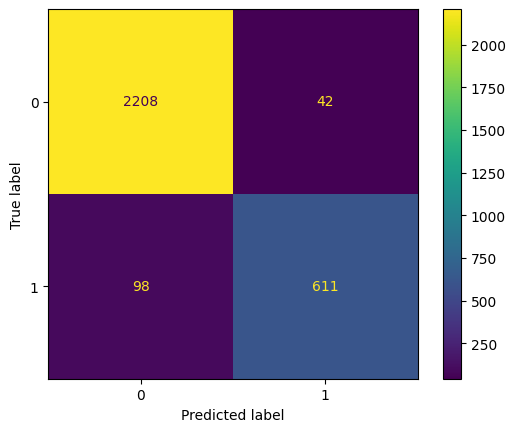

In [49]:
# Array of values for confusion matrix
rf2_model = rf2_cv.best_estimator_

# Making predictions on the test set
preds = rf2_model.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2_model.classes_)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2_model.classes_)
disp.plot(values_format='');

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. But this is still a strong model.

For exploratory purpose, I will inspect the splits of the decision tree model and the most important features in the random forest model. 

#### Decision tree splits

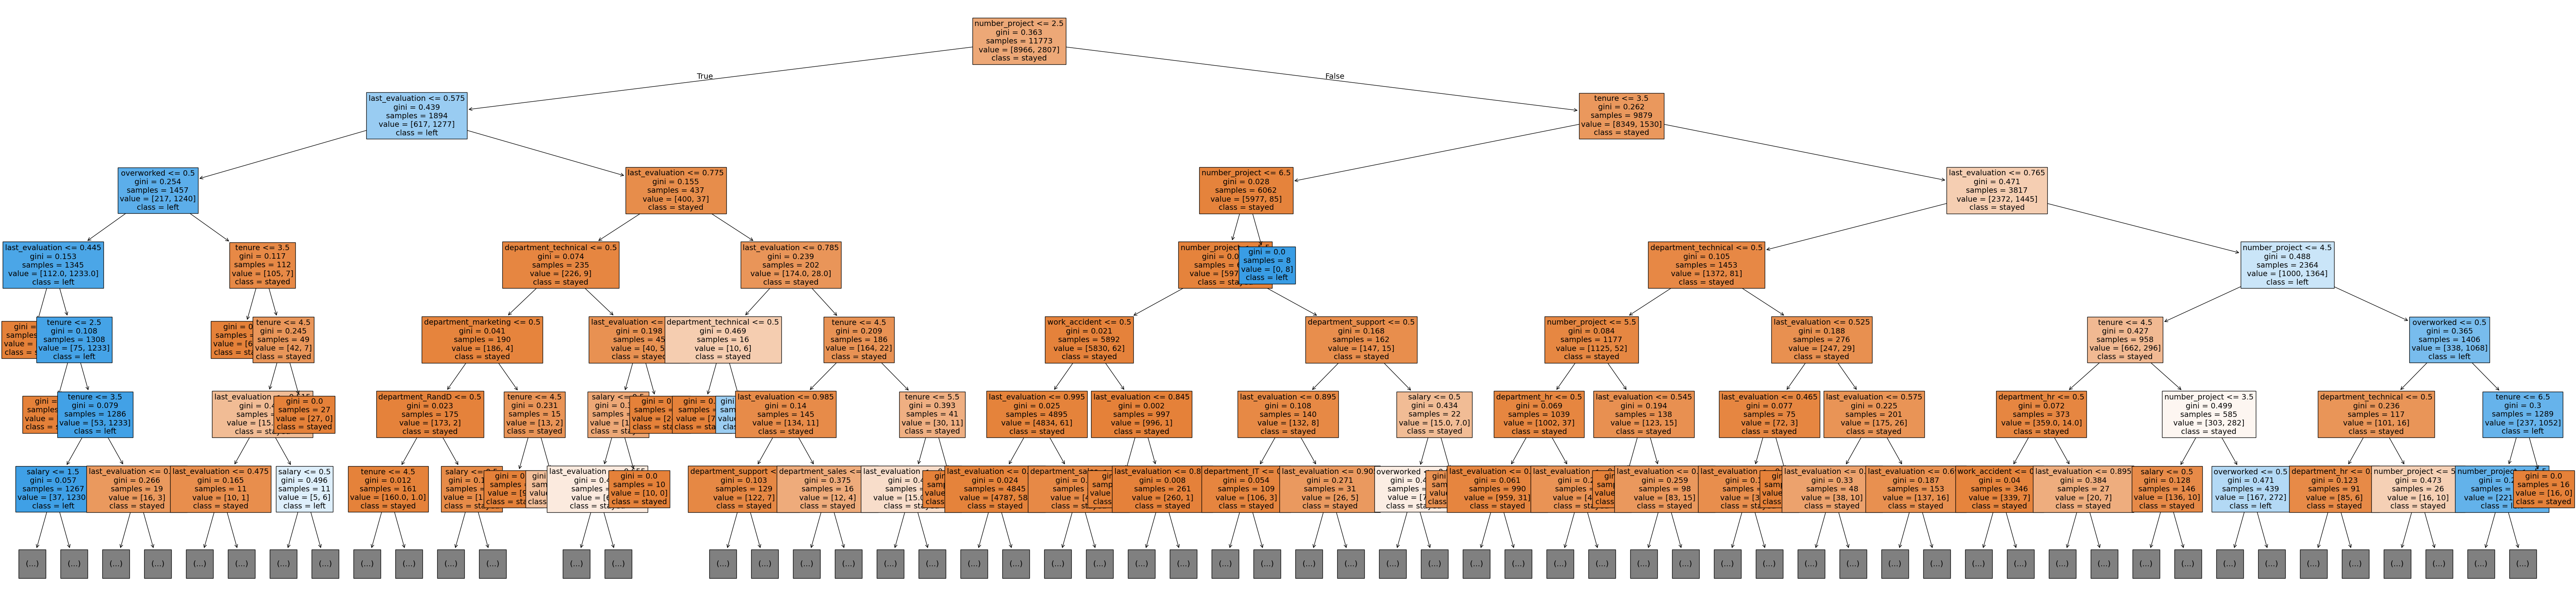

In [50]:
# Plotting the decision tree splits
plt.figure(figsize=(85,20))
plot_tree(tree2_cv.best_estimator_, max_depth=6, fontsize=14, feature_names= X_train.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True)
plt.show()

#### Decision tree feature importance

In [53]:
tree2_importances = pd.DataFrame(tree2_cv.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X_train.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extracting the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
number_project,0.320152
last_evaluation,0.302190
tenure,0.266242
overworked,0.081893
salary,0.011013
department_technical,0.004560
work_accident,0.003287
department_sales,0.002715
department_support,0.002485
department_IT,0.001639


Barplot to visualize the decision tree feature importances.

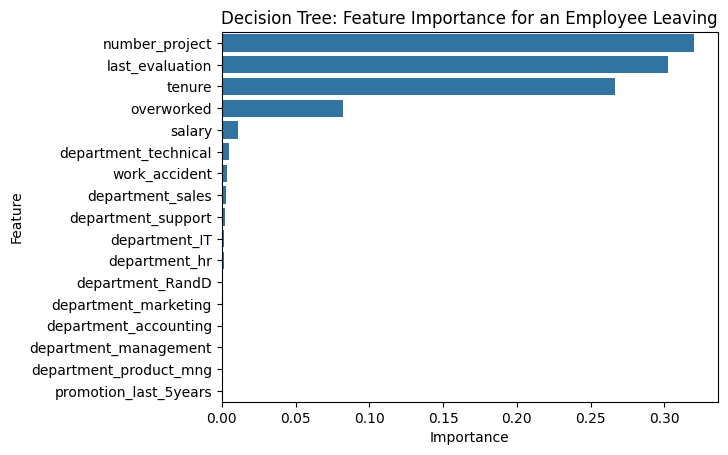

In [54]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importance for an Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()


The barplot above shows that in this decision tree model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`.

#### Random forest feature importance

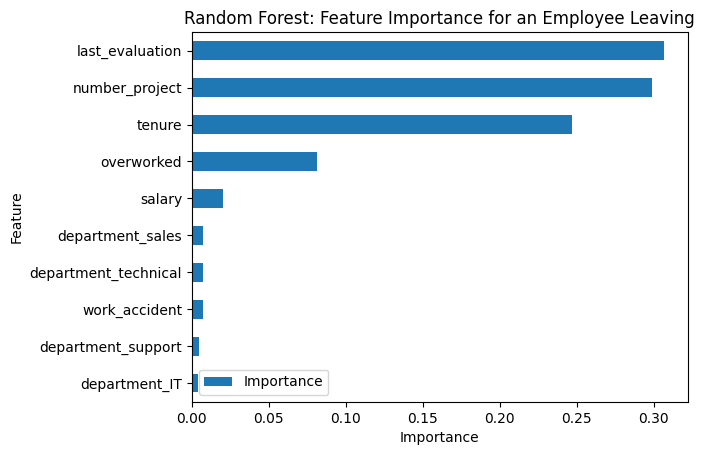

In [55]:
# Feature importances
feat_imp = rf2_cv.best_estimator_.feature_importances_

# Indices of top 10 features
ind = np.argpartition(rf2_cv.best_estimator_.feature_importances_, -10)[-10:]

# Column labels of top 10 features 
feat = X_train.columns[ind]

# Filtering `feat_imp` to consist of top 10 feature importances
feat_imp = feat_imp[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_imp})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importance for an Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure` and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

## XGBoost Model

In [61]:
# Instantiating XGBoost model
xgb2 = XGBClassifier(eval_metric='logloss')


# Dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


# Dictionary of scoring metrics to capture
scoring = {
    'accuracy' : 'accuracy',
    'f1' : 'f1',
    'precision' : 'precision',
    'recall' : 'recall',
    'roc_auc' : 'roc_auc'
}

# Instantiating GridSearch
xgb2_cv = GridSearchCV(xgb2, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [62]:
%%time
# fitting the model
xgb2_cv.fit(X_train, y_train)

CPU times: total: 15min 58s
Wall time: 2min 55s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [ ]:
# Saving the model to a file
joblib.dump(xgb2_cv, 'xgb2_cv.pkl')

In [60]:
# Loading the model from a file
xgb2_cv = joblib.load('xgb2_cv.pkl')

In [63]:
# Best AUC score on CV
xgb2_cv.best_score_

np.float64(0.9827037759482631)

Optimal values for the parameters of the XGBoost model 

In [64]:
# Checking the best parameters 
xgb2_cv.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200,
 'subsample': 1}

Predicting and evaluating the XGBoost model on testing set

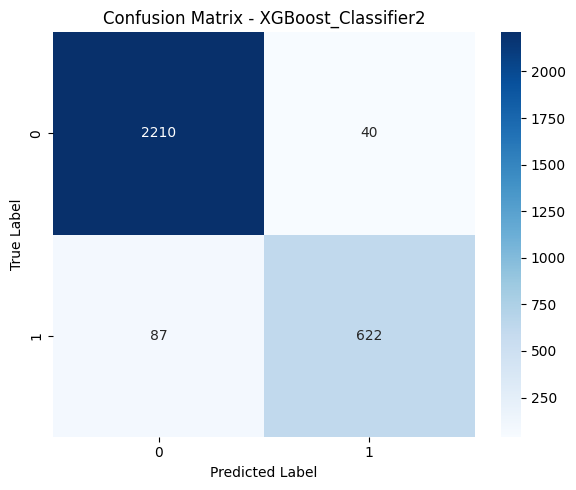

In [ ]:
# Best estimator model on CV
xgb2_model = xgb2_cv.best_estimator_
y_pred = xgb2_model.predict(X_test)

# Confusion matrix
plot_classification_matrix(xgb2_model, X_test, y_test, model_name='XGBoost_Classifier2')


In [77]:
# Score of best estimator model on test data
xgb2_test_score = get_scores('XGBoost model 2', xgb2_cv, X_test, y_test)
print(xgb2_test_score)

             model  precision    recall        f1  accuracy       AUC
0  XGBoost model 2   0.939577  0.877292  0.907367   0.95708  0.929757


In [ ]:
# Classification report for XGBoost model on test data(test score)
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.96      0.98      0.97      2250
    Predicted would leave       0.94      0.88      0.91       709

                 accuracy                           0.96      2959
                macro avg       0.95      0.93      0.94      2959
             weighted avg       0.96      0.96      0.96      2959



In [ ]:
# checking the best estimator scores of the XGBoost CV object on "predicted would leave"(validation score)
xgb2_cv_results = make_results("XGBoost cv 2", xgb2_cv, 'auc')
print(xgb2_cv_results)

          model  precision    recall        F1  accuracy       auc
0  XGBoost cv 2   0.923864  0.917686  0.920375  0.962286  0.982704


The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, I can be confident that this model's performance on this data is representative of how it will perform on new, unseeen data.

In [78]:
# Comparing all score on validation data used by cv
print(tree2_cv_results)
print(rf2_cv_results)
print(xgb2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.899059  0.888465  0.892618  0.949291  0.974839
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.914877  0.932994  0.923141  0.963305  0.983876
          model  precision    recall        F1  accuracy       auc
0  XGBoost cv 2   0.923864  0.917686  0.920375  0.962286  0.982704


In [81]:
# Comparing all scores on test data
print(tree2_test_score)
print(rf2_test_scores)
print(xgb2_test_score)

                   model  precision    recall        f1  accuracy       AUC
0  Decision tree model 2   0.925926  0.881523  0.903179  0.954714  0.929651
                   model  precision    recall       f1  accuracy       AUC
0  random forest model 2   0.935681  0.861777  0.89721  0.952687  0.921555
             model  precision    recall        f1  accuracy       AUC
0  XGBoost model 2   0.939577  0.877292  0.907367   0.95708  0.929757


## Evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example. 
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






💭 
### Reflect on these questions as you complete the executing stage.

- What key insights emerged from your model(s)?
- What business recommendations do you propose based on the models built?
- What potential recommendations would you make to your manager/company?
- Do you think your model could be improved? Why or why not? How? 
- Given what you know about the data and the models you were using, what other questions could you address for the team? 
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?



## Results and Evaluation

### Summary of model results

**Logistic Regression**

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The random forest modestly outperformed the decision tree model. 

### Conclusion, Recommendations, Next Steps

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following are some recommendations to the stakeholders:

* Cap the number of projects that employees can work on. `(3-4 projects)`
* Consider `promoting employees` who have been with the company for atleast `four years`, or conduct further investigation about why four-year tenured employees are so dissatisfied. 
* Either `reward employees` for `working longer hours`, or don't require them to do so. 
* If employees aren't familiar with the company's `overtime pay policies`, inform them about this. If the expectations around workload and time off aren't explicit, make them clear. 
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts. 
* `High evaluation scores` should `not` be reserved for employees who `work 200+ hours per month`. Consider a `proportionate scale` for `rewarding employees` who `contribute` more/put in more effort. 

**Next Steps**

It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_evaluation` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score.  